# Importing Libraries

In [117]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import seaborn as sns
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage import exposure
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4,DenseNet121,ResNet50,MobileNetV3Small
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

# Loading the Data

In [3]:
dir_names=["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]
images=[]
labels=[]

In [4]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

In [5]:
for i, dir_name in enumerate(dir_names):
    os.chdir('./'+dir_name)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            labels.append(i)
    os.chdir('../')

<Axes: ylabel='count'>

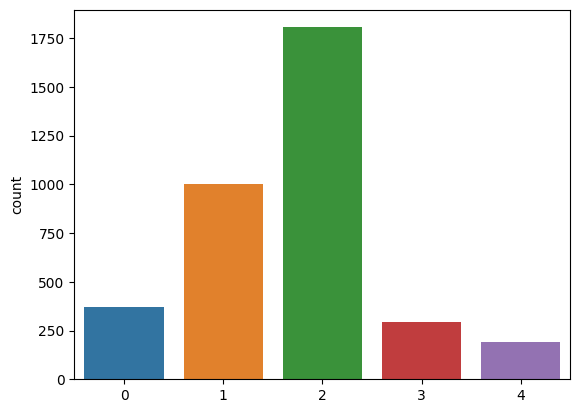

In [6]:
sns.countplot(x=labels)

In [7]:
(np.array(labels)==4).sum()

193

In [8]:
os.chdir('/kaggle/input/diabetic-retinopathy-resized-arranged')

# Combining two Datasets

In [9]:
max_images_per_label = 500
for i, _ in enumerate(dir_names):
    os.chdir('./'+f'{i}')
    imgs_names = os.listdir()
    count = labels.count(dir_names)
    for img_name in imgs_names:
        if count < max_images_per_label:
            with Image.open(img_name) as image:
                image = np.array(image)
                images.append(image)
                labels.append(i)
                count += 1
    os.chdir('../')

<Axes: ylabel='count'>

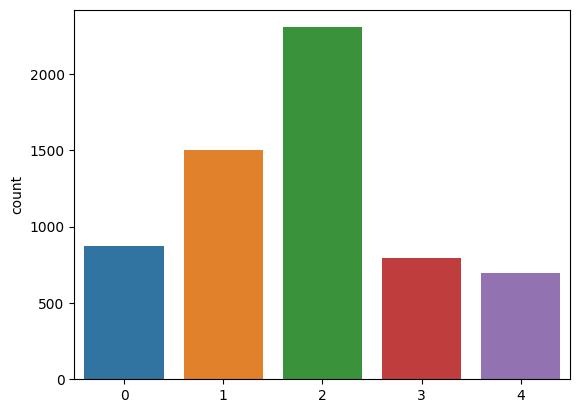

In [10]:
sns.countplot(x=labels)

In [11]:
(np.array(labels)==4).sum()

693

# Balancing Data

In [12]:
threshold_per_class = 700
filtered_images = []
filtered_labels = []
class_counts = {label: 0 for label in set(labels)}
for image, label in zip(images, labels):
    if class_counts[label] < threshold_per_class:
        filtered_images.append(image)
        filtered_labels.append(label)
        class_counts[label] += 1

<Axes: ylabel='count'>

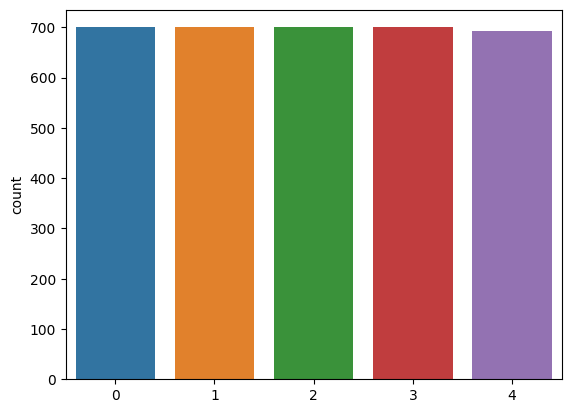

In [13]:
sns.countplot(x=filtered_labels)

In [14]:
len(filtered_images),len(filtered_labels)

(3493, 3493)

# Pre-Processing

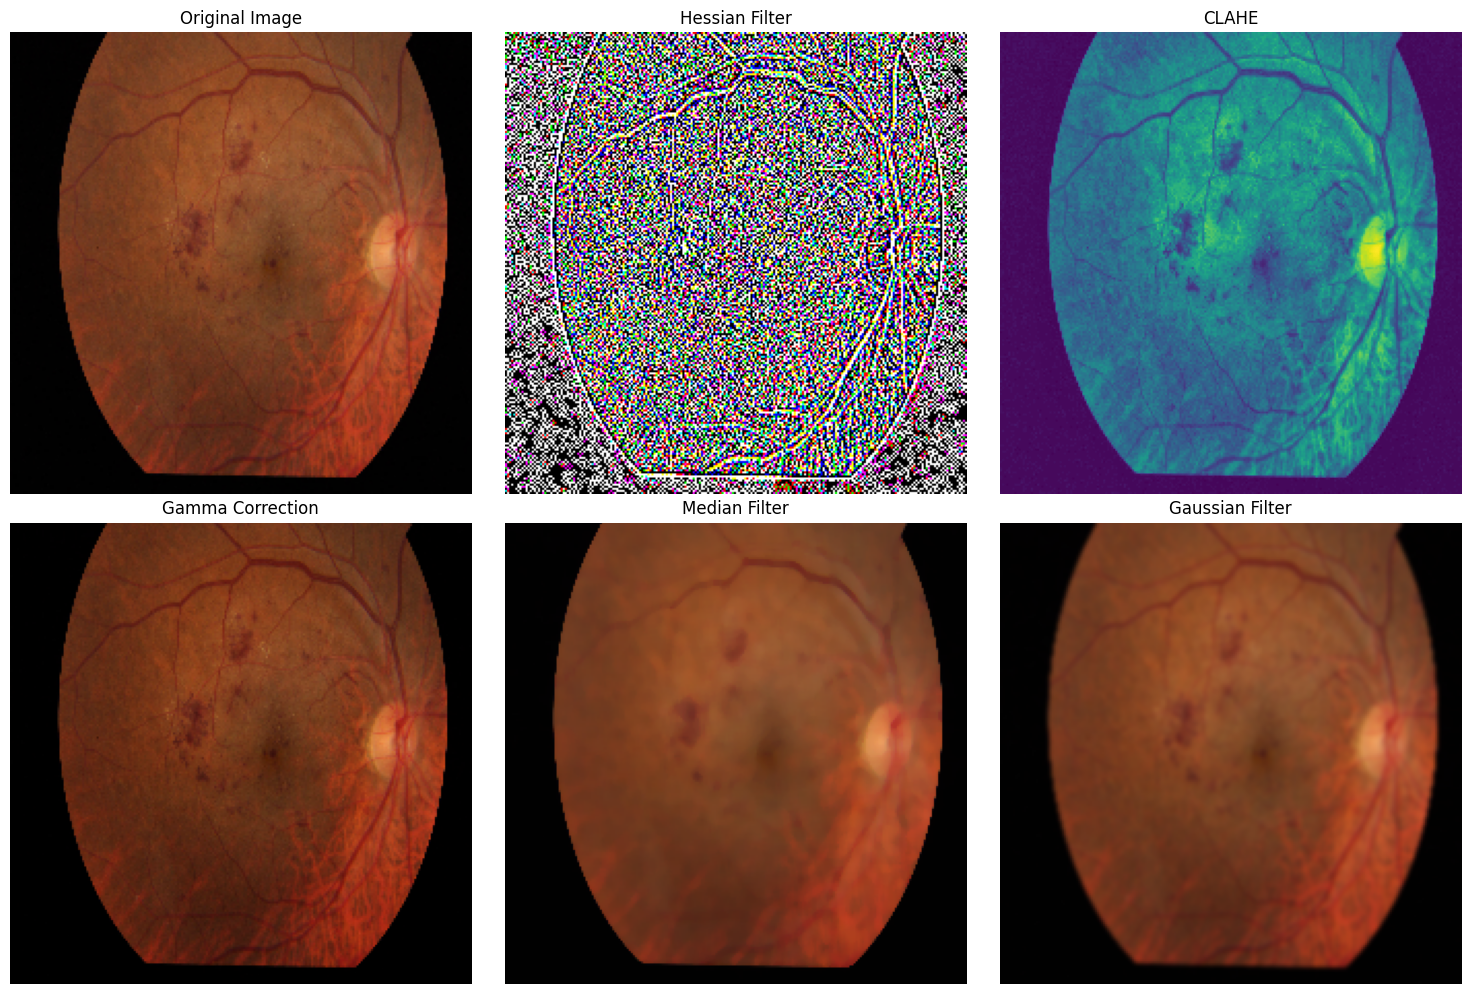

In [126]:
img_rgb=filtered_images[260]
processing_techniques = [
    ('Original Image', img_rgb),
    ('Hessian Filter', cv2.Laplacian(img_rgb, cv2.CV_64F)),
    ('CLAHE', cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))),
    ('Gamma Correction', exposure.adjust_gamma(img_rgb, gamma=1.2)),
    ('Median Filter', cv2.medianBlur(img_rgb, 5)),  # Applying Median filter with kernel size 5x5
    ('Gaussian Filter', cv2.GaussianBlur(img_rgb, (5, 5), 0))  # Applying Gaussian filter with kernel size 5x5
]
plt.figure(figsize=(15, 10))
for i, (title, processed_image) in enumerate(processing_techniques, start=1):
    plt.subplot(2, 3, i)
    plt.imshow(processed_image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    processed_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return processed_image

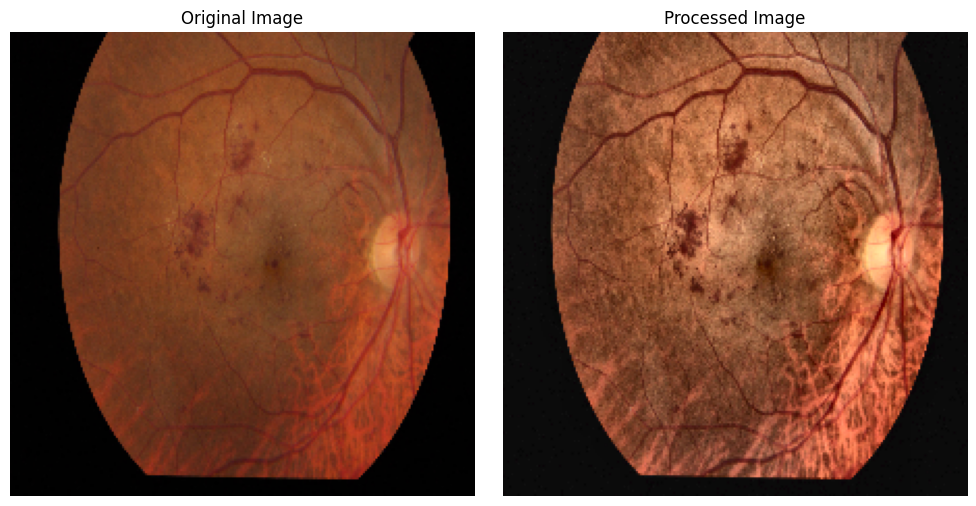

In [128]:
image_to_process = [(img_rgb, 'Original Image'), (preprocess_image(img_rgb), 'Processed Image')]
plt.figure(figsize=(10, 5))
for i, (image, title) in enumerate(image_to_process, start=1):
    plt.subplot(1, 2, i)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
preprocessed_images = [preprocess_image(img) for img in filtered_images]
preprocessed_images_resized = [Image.fromarray(img).resize((224, 224)) for img in preprocessed_images]
preprocessed_images_array = np.array([np.array(img) for img in preprocessed_images_resized])

In [20]:
filtered_labels = np.array(filtered_labels)
shuffled_indices = np.random.permutation(len(filtered_labels))
shuffled_preprocessed_images = preprocessed_images_array[shuffled_indices]
shuffled_filtered_labels = filtered_labels[shuffled_indices]

# Data Augmentation

In [22]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-10, 10)), 
    iaa.Affine(scale=(0.8, 1.2)) 
])

In [23]:
augmented_images = []
augmented_labels = []

In [24]:
for image, label in zip(shuffled_preprocessed_images, shuffled_filtered_labels):
    augmented_image = seq(image=image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [26]:
len(augmented_labels)

3493

In [27]:
final_images = np.concatenate((shuffled_preprocessed_images, augmented_images), axis=0)
final_labels = np.concatenate((shuffled_filtered_labels, augmented_labels), axis=0)
shuffled_indices = np.random.permutation(len(final_labels))
final_images = final_images[shuffled_indices]
final_labels = final_labels[shuffled_indices]

In [28]:
len(final_images)

6986

<Axes: ylabel='count'>

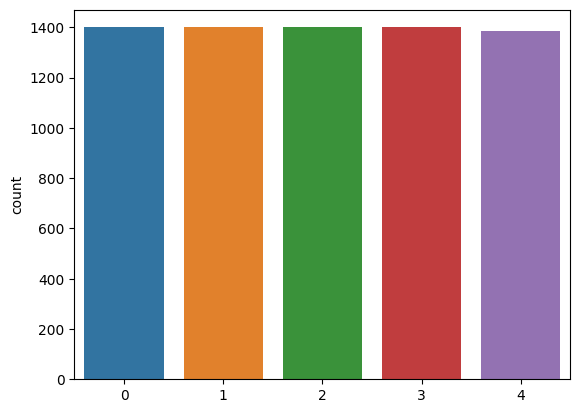

In [29]:
sns.countplot(x=final_labels)

In [30]:
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + f'{labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

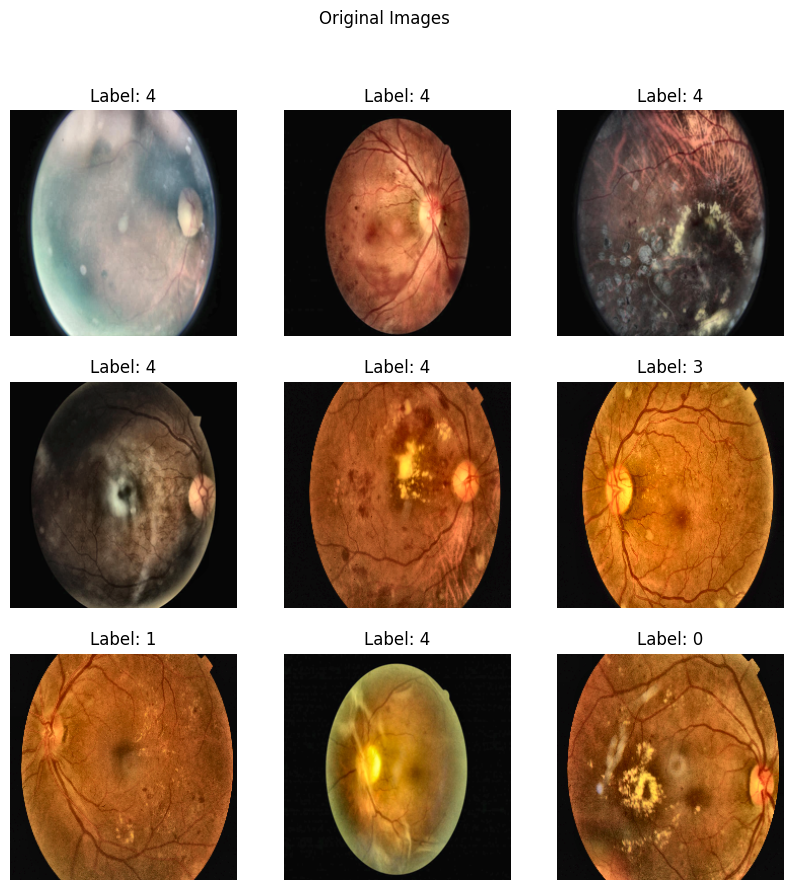

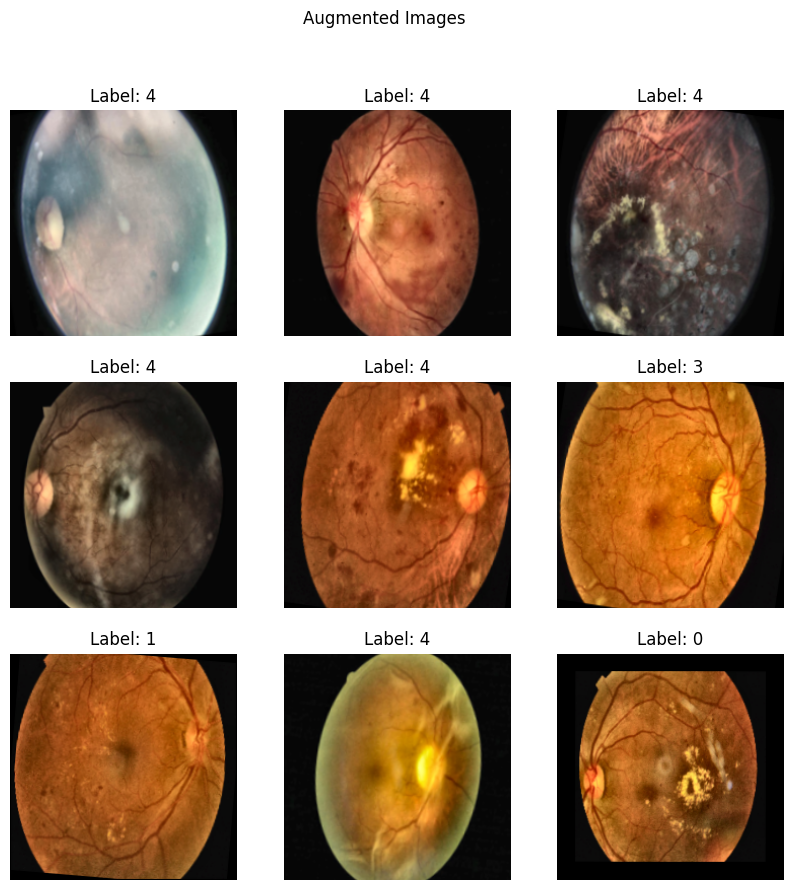

In [31]:
plot_images(shuffled_preprocessed_images[:9],shuffled_filtered_labels[:9], title='Original Images')
plot_images(augmented_images[:9], augmented_labels[:9], title='Augmented Images')

# Splitting the Data

In [32]:
x_train,x_test,y_train,y_test=train_test_split(final_images,final_labels,test_size=.2,stratify=final_labels,random_state=404)

# Transfer Learning Models

In [63]:
def build_model(pre_trained):
    x = pre_trained.output
    x = layers.Flatten()(x)  # Flatten the output from the base model
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=pre_trained.input, outputs=predictions)    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# EfficientNetB4

In [35]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [36]:
model=build_model(base_model)

In [64]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

In [38]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/100


I0000 00:00:1714058337.488481     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714058337.596729     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2309 - loss: 3.1772   

W0000 00:00:1714058427.288911     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.2311 - loss: 3.1786 - val_accuracy: 0.2868 - val_loss: 3.0818 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.2602 - loss: 3.1096 - val_accuracy: 0.3183 - val_loss: 2.6368 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.3087 - loss: 2.7525 - val_accuracy: 0.4607 - val_loss: 2.3041 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.3446 - loss: 2.4994 - val_accuracy: 0.5293 - val_loss: 2.0822 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.3726 - loss: 2.2999 - val_accuracy: 0.5193 - val_loss: 1.9731 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 279ms/step - accuracy: 0.4101 - loss: 2.1101 - val_accuracy: 0.5100 - val_loss: 1.8368 - learning_rate: 0.0010
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.4475 - loss: 1.9720 - 

In [39]:
models=['EfficientNetB4','DenseNet','ResNet','VGG16']
accuracies=[]
cms=[]
histories=[]
trained_models=[]

In [40]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.7384 - loss: 0.9487


In [44]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# DenseNet 121

In [45]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [46]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 102s 174ms/step - accuracy: 0.2690 - loss: 2.5187 - val_accuracy: 0.4435 - val_loss: 1.9178 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.3754 - loss: 2.0589 - val_accuracy: 0.4764 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4128 - loss: 1.9348 - val_accuracy: 0.4564 - val_loss: 1.6536 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4401 - loss: 1.7574 - val_accuracy: 0.4778 - val_loss: 1.5564 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4709 - loss: 1.6341 - val_accuracy: 0.4878 - val_loss: 1.5322 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4802 - loss: 1.6223 - val_accuracy: 0.5250 - val_loss: 1.4258 - learning_rate: 0.0010
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4989 -

In [47]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.6648 - loss: 0.9368


# ResNet 50

In [50]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [51]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
model=build_model(base_model)

In [52]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2929 - loss: 3.0188

W0000 00:00:1714060390.552794     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714060400.961910     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


350/350 ━━━━━━━━━━━━━━━━━━━━ 63s 107ms/step - accuracy: 0.2930 - loss: 3.0184 - val_accuracy: 0.4592 - val_loss: 2.4461 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.4040 - loss: 2.4180 - val_accuracy: 0.5572 - val_loss: 1.8095 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4650 - loss: 1.9141 - val_accuracy: 0.5737 - val_loss: 1.5522 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4997 - loss: 1.6782 - val_accuracy: 0.5916 - val_loss: 1.4239 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5053 - loss: 1.6572 - val_accuracy: 0.6023 - val_loss: 1.3814 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5452 - loss: 1.5204 - val_accuracy: 0.6459 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.5702 - loss: 1.441

In [53]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7395 - loss: 0.8446


# MobileNetV3Small

In [65]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=build_model(base_model)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [66]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=128)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 613ms/step - accuracy: 0.2512 - loss: 2.6579 - val_accuracy: 0.3670 - val_loss: 2.4793 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3583 - loss: 2.2903 - val_accuracy: 0.5122 - val_loss: 1.9131 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4025 - loss: 2.0538 - val_accuracy: 0.5393 - val_loss: 1.7283 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4538 - loss: 1.8757 - val_accuracy: 0.5823 - val_loss: 1.6018 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4968 - loss: 1.7469 - val_accuracy: 0.6295 - val_loss: 1.4854 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5151 - loss: 1.6536 - val_accuracy: 0.6373 - val_loss: 1.4221 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5577 - loss: 1.5391 - val_a

In [67]:
predicted_probs = model.predict(x_test)
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracies.append(model.evaluate(x_test,y_test)[1])
cms.append(cm)
trained_models.append(model)
histories.append(history)

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.7176 - loss: 1.0572


# Evaluating the Models

In [134]:
models_names=['EfficientNetB4','DenseNet 121','ResNet 50','MobileNetV3 Small']
data = {'Model': models_names, 'Accuracy': accuracies}
df = pd.DataFrame(data)
df.head()

Model  Accuracy
0     EfficientNetB4  0.733190
1       DenseNet 121  0.680257
2          ResNet 50  0.755365
3  MobileNetV3 Small  0.726037

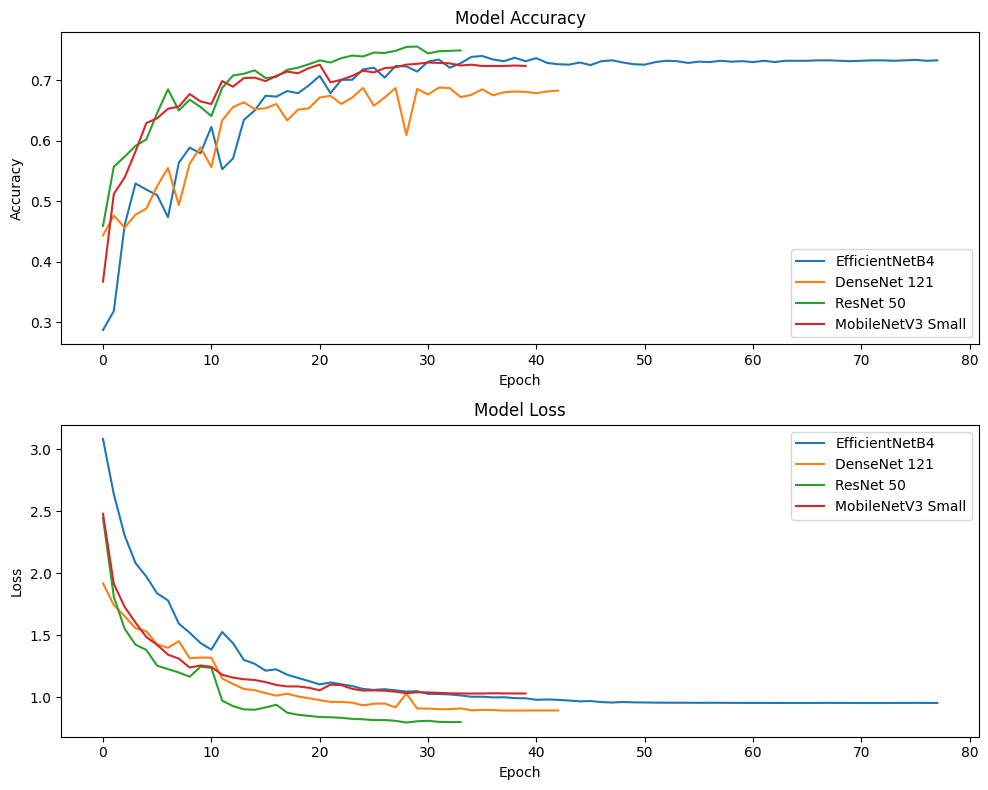

In [135]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for history, model_name in zip(histories, models_names):
    axs[0].plot(history.history['val_accuracy'], label=model_name)
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[1].plot(history.history['val_loss'], label=model_name  )
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

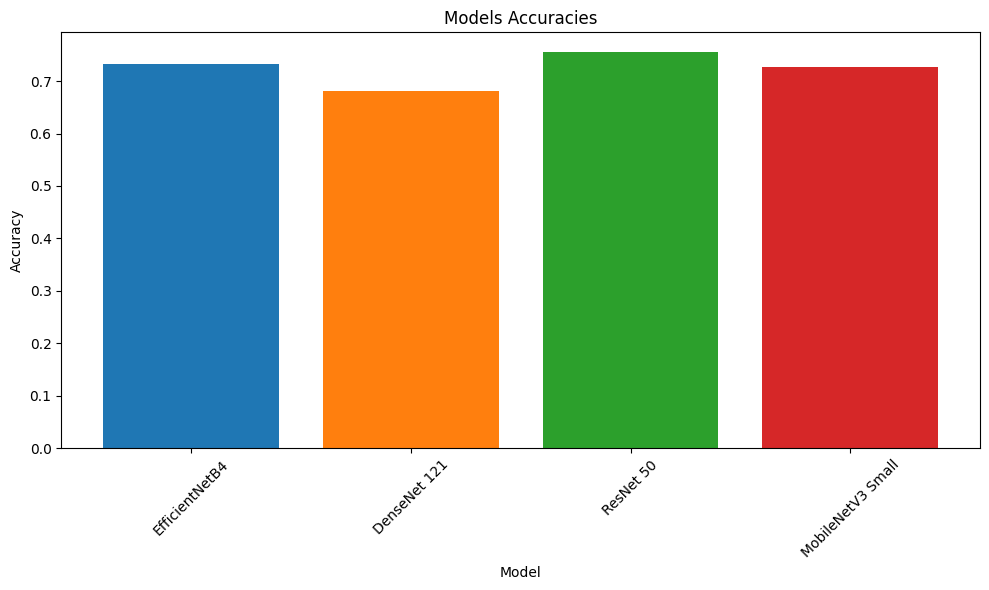

In [136]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Models Accuracies')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

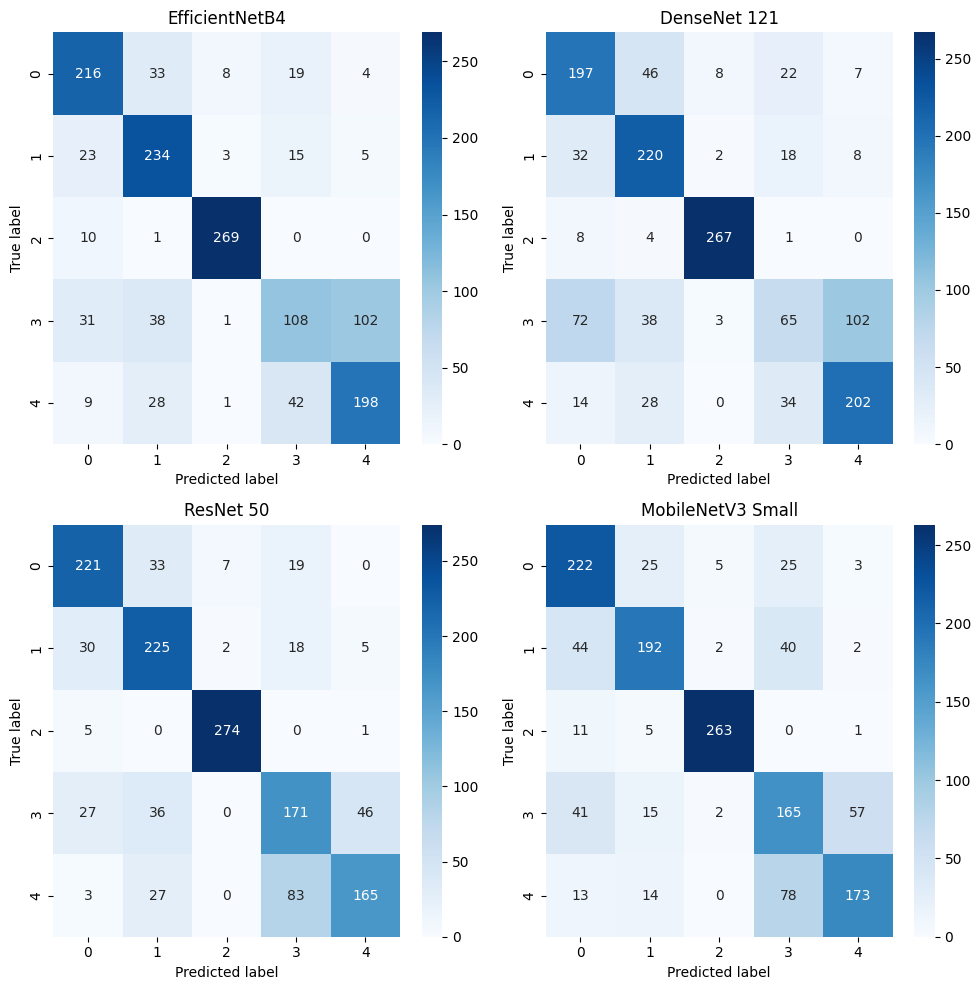

In [137]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax, cm, model_name in zip(axs.flatten(), cms, models_names):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

# Choosing the Best Model

In [110]:
resnet=trained_models[2]

In [111]:
resnet.save('/kaggle/working/resnet.h5')